In [281]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import torch, torch_geometric
import wandb
import utils
from IPython.display import clear_output

In [448]:
def get_model_type(x):
    if isinstance(x, str) and x.startswith("1WL+NN"): return "1-WL+NN"
    elif isinstance(x, str) and (x.startswith("GAT") or x.startswith("GIN") or x.startswith("GCN")): return "GNN"
    else: return pd.NA

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("eric-bill/BachelorThesisExperiments")

data = []
for run in runs:
    if run.state == "finished":
        data.append(run.summary._json_dict | run.config | {'Tags' : run.tags[0] if len(run.tags) > 0 else pd.NA} | {'name' : run.name})

runs_df = pd.DataFrame(data)
runs_df['model_type'] = runs_df['model'].apply(get_model_type)
runs_df.to_csv("project.csv")

In [449]:
dataset_list = ["ENZYMES", "PROTEINS", "IMDB-BINARY", "IMDB-MULTI", "NCI1"]

data = []
for dataset_name in dataset_list:
    dataset = torch_geometric.datasets.TUDataset(root=f"datasets", name=dataset_name).shuffle()
    unbalance = utils.calc_shannon_diversity(dataset)
    data.append([dataset_name, unbalance])

clear_output()
df_unbalances = pd.DataFrame(data, columns=["dataset", "shannon_diversity"])
df_unbalances.pivot_table(columns="dataset", values="shannon_diversity")

dataset,ENZYMES,IMDB-BINARY,IMDB-MULTI,NCI1,PROTEINS
shannon_diversity,1.0,1.0,1.0,1.0,0.973


In [450]:
accuracies = pd.read_csv("results/wandb_accuracies.csv")
pivot_table = accuracies.pivot(index="k_wl", columns="Dataset", values="Max Accuracy")
pivot_table.style.highlight_max(color = 'lightgreen', axis = 0)

Dataset,ENZYMES,IMDB-Binary,IMDB-Multi,NCI1,PROTEINS
k_wl,,,,,
0,0.813333,0.606000,0.441333,0.913382,0.919137
1,1.000000,0.886000,0.632667,0.995377,0.997305
2,1.000000,0.886000,0.632667,0.998054,0.997305
3,1.000000,0.886000,0.632667,0.998297,0.997305
4,1.000000,0.886000,0.632667,0.998297,0.997305
5,1.000000,0.886000,0.632667,0.998297,0.997305


In [451]:
datasets = runs_df['dataset'].dropna().unique()

rows = []
for ds in datasets:
    gnn_runs = runs_df[(runs_df['Tags'] == 'sweep_gnn:basic_pool') & (runs_df['dataset'] == ds)]['test_accuracy']
    best_gnn_index = gnn_runs.idxmax()
    best_gnn = runs_df.loc[best_gnn_index]
    
    wlnn_runs = runs_df[(runs_df['Tags'] == 'sweep_wlnn:basic_pool') & (runs_df['dataset'] == ds)]['test_accuracy']
    best_wlnn_index = wlnn_runs.idxmax()
    best_wlnn = runs_df.loc[best_wlnn_index]
    
    rows.append({'dataset' : ds, 'best_gnn_model' : best_gnn['name'], 'best_gnn_test_acc' : f"{round(best_gnn['test_accuracy'], 2)} ± {round(best_gnn['test_accuracy_std'], 2)}",
                    'num_gnn_runs' : gnn_runs.shape[0], 'best_wlnn_model' : best_wlnn['name'], 
                    'best_wlnn_test_acc' : f"{round(best_wlnn['test_accuracy'], 2)} ± {round(best_wlnn['test_accuracy_std'], 2)}", 'num_wlnn_runs' : wlnn_runs.shape[0]})
                

best_models = pd.DataFrame(rows)
best_models

,dataset,best_gnn_model,best_gnn_test_acc,num_gnn_runs,best_wlnn_model,best_wlnn_test_acc,num_wlnn_runs
0,IMDB-BINARY,GCN:Mean: 08.06.2023 01:51:53,73.9 ± 4.25,93,1WL+NN:Embedding-Mean: 08.06.2023 16:29:25,72.16 ± 4.08,34
1,NCI1,GIN:Max: 08.06.2023 14:00:49,77.31 ± 2.24,101,1WL+NN:Embedding-Sum: 06.06.2023 11:22:14,83.58 ± 1.92,156
2,ENZYMES,GAT:Sum: 05.06.2023 01:33:51,34.4 ± 7.0,224,1WL+NN:Embedding-Sum: 03.06.2023 05:40:02,48.27 ± 7.95,450
3,PROTEINS,GIN:Max: 02.06.2023 04:21:50,74.01 ± 4.16,126,1WL+NN:Embedding-Max: 01.06.2023 02:54:32,75.2 ± 3.92,493


In [453]:
def calc_quantil_performance(dataframe, grouping_columns, quantils):
    rows = []

    for (grouping_values, grouped_dataframe) in dataframe.groupby(grouping_columns):
        for q in quantils:
            index = grouped_dataframe.index[grouped_dataframe['test_accuracy'] >= grouped_dataframe['test_accuracy'].quantile(1 - q, interpolation='lower')]
            grouping_info = {column: value for column, value in zip(grouping_columns, grouping_values)}
            
            for i in index:
                rows.append({'quantil' : q, 'accuracy' : dataframe.loc[i]['train_accuracy'], 'acc_type' : 'train_acc'} | grouping_info)
                rows.append({'quantil' : q, 'accuracy' : dataframe.loc[i]['val_accuracy'], 'acc_type' : 'val_acc'} | grouping_info)
                rows.append({'quantil' : q, 'accuracy' : dataframe.loc[i]['test_accuracy'], 'acc_type' : 'test_acc'} | grouping_info)
                rows.append({'quantil' : q, 'accuracy' : dataframe.loc[i]['train_accuracy'] - dataframe.loc[i]['test_accuracy'], 'acc_type' : 'abs_diff'} | grouping_info)

    return pd.DataFrame(rows)


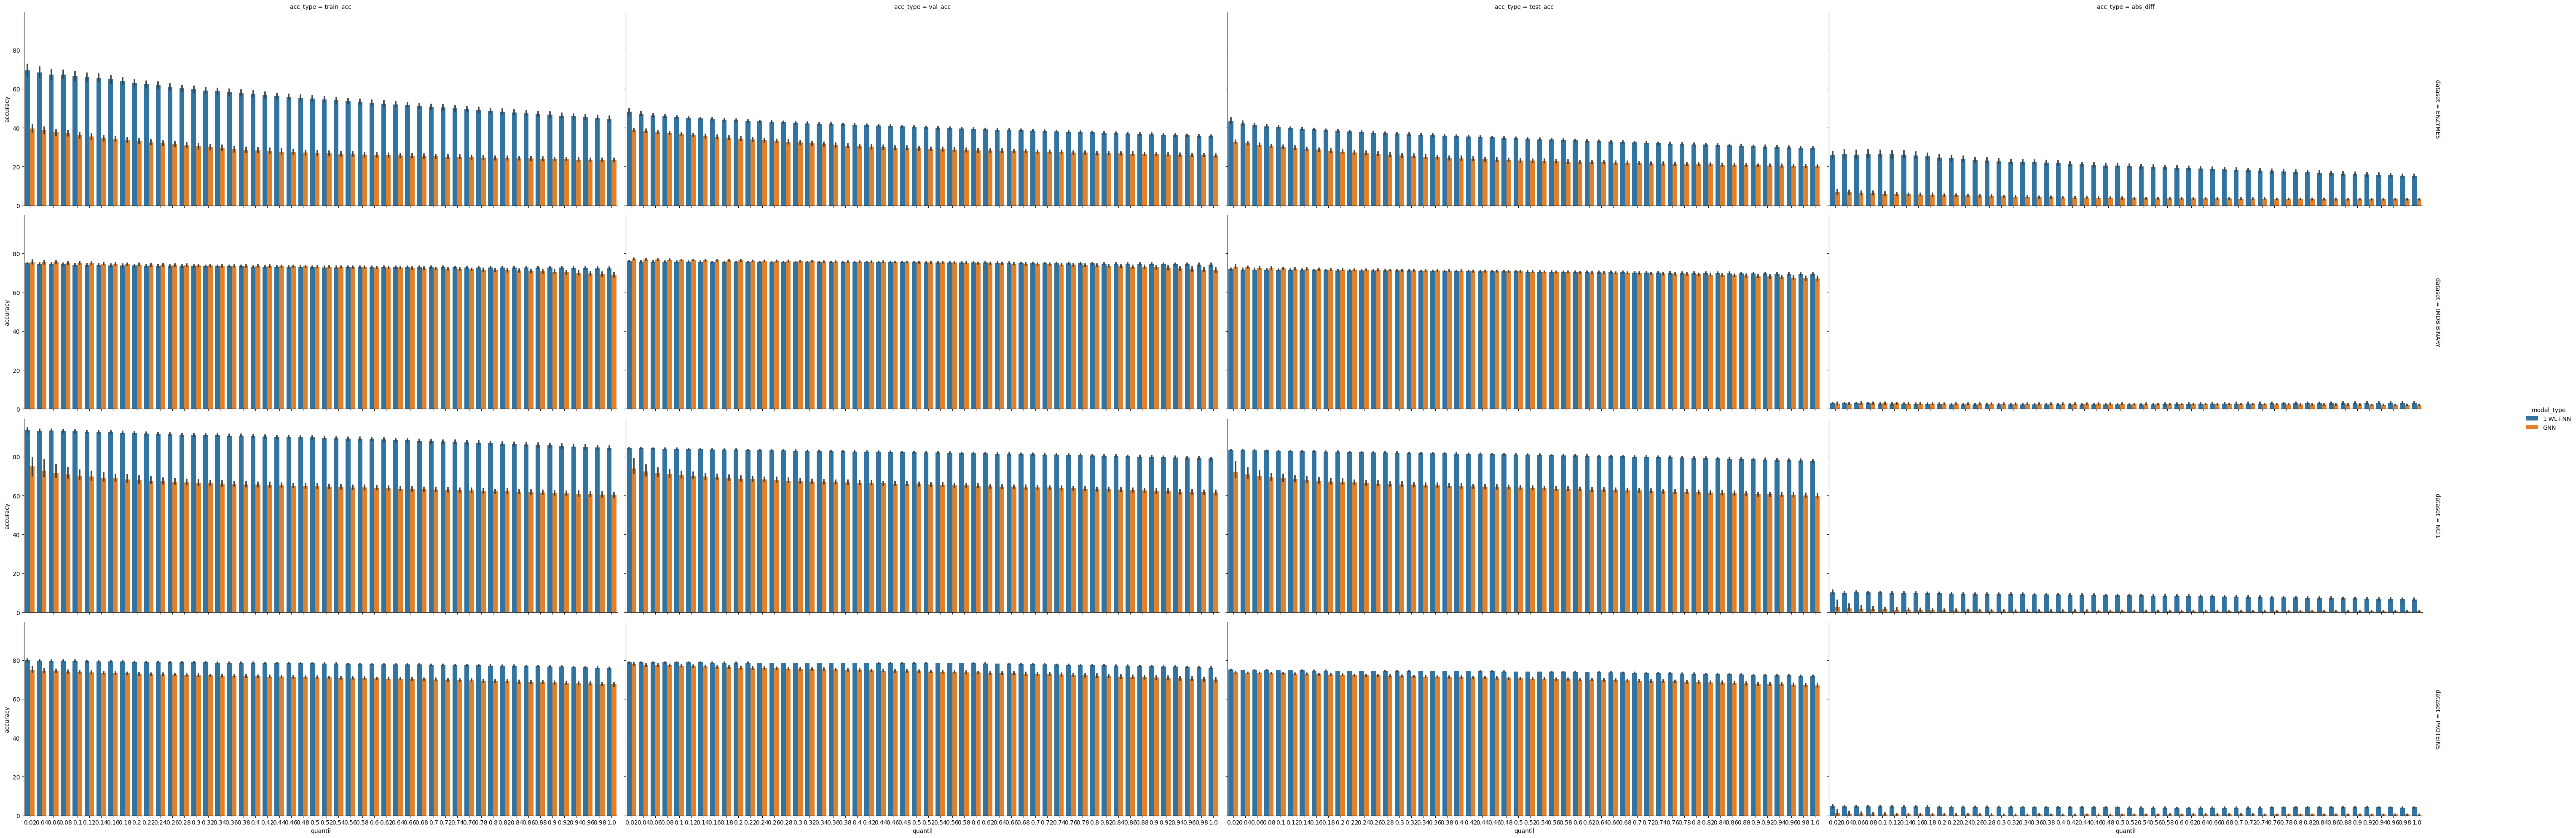

In [487]:
df = runs_df[(runs_df['dataset'].notnull()) & (runs_df['model_type'].notnull())]
df_diff = calc_quantil_performance(df, grouping_columns=['model_type', 'dataset'], quantils=[i/50 for i in range(1, 50+1)])

sns.catplot(data=df_diff, x="quantil", y="accuracy", hue="model_type", col="acc_type", row="dataset", kind="bar", aspect=3, margin_titles=True)

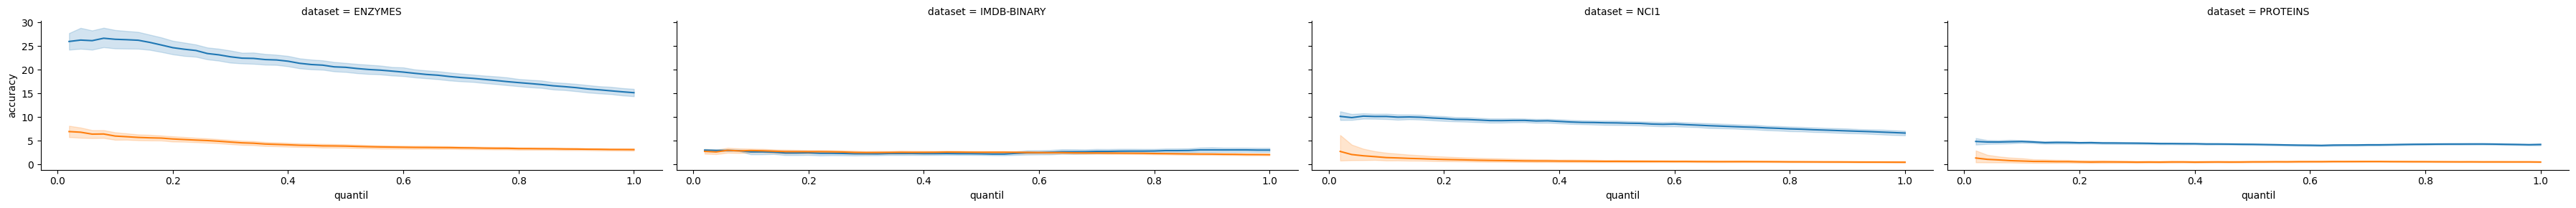

In [489]:
df_abs_diff = df_diff[df_diff['acc_type'] == 'abs_diff']
g = sns.FacetGrid(df_abs_diff, col="dataset", hue="model_type", margin_titles=True, aspect=3)
g.map(sns.lineplot, "quantil", "accuracy")

Text(0.5, 1.0, 'Train accuracy - Test accuracy')

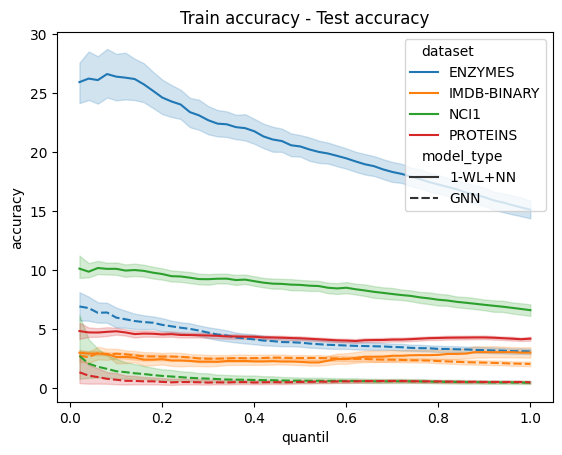

In [496]:
sns.lineplot(data=df_abs_diff, x="quantil", y="accuracy", hue='dataset', style='model_type', err_style='band').set_title("Train accuracy - Test accuracy")

Text(0.5, 1.0, '1-WL+NN - GNN')

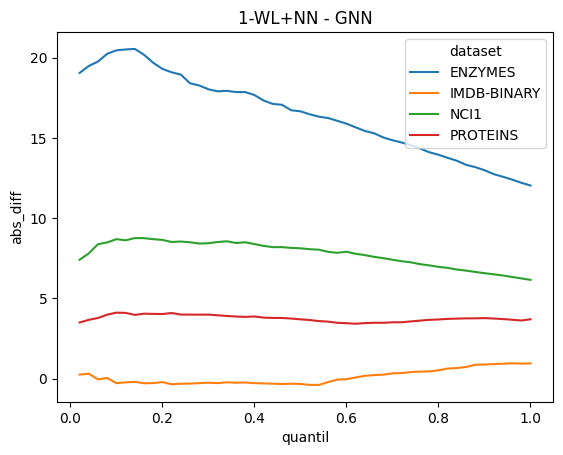

In [492]:
data = []
for (grouped_col, grouped_df) in df_abs_diff.groupby(['dataset', 'quantil']):
    mean_wlnn_diff = grouped_df[grouped_df['model_type'] == '1-WL+NN']['accuracy'].mean()
    mean_gnn_diff = grouped_df[grouped_df['model_type'] == 'GNN']['accuracy'].mean()

    data.append({'dataset' : grouped_col[0], 'quantil' : grouped_col[1], 'abs_diff' : mean_wlnn_diff - mean_gnn_diff})

df_diff_mean = pd.DataFrame(data)
sns.lineplot(data=df_diff_mean, x="quantil", y="abs_diff", hue='dataset').set_title("1-WL+NN - GNN")

In [ ]:
def calc_svm_boundary_contour(X, Y, clf, n_points=100):
    """
    Calculate the decision boundary contour of a trained SVM classifier.

    Args:
        X: Numpy array of shape (n_samples, 2) containing the samples.
        Y: Numpy array of shape (n_samples,) containing the labels.
        clf: Trained SVM classifier.
        n_points: Number of points to use for the contour.

    Returns:
        Tuple (xx, yy, Z) where xx and yy are numpy arrays of shape (n_points, n_points) containing the x and y
        coordinates of the contour points and Z is a numpy array of shape (n_points, n_points) containing the
        corresponding decision values.
    """
    # Create a grid of points
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h_x0 = (x0_max - x0_min) / n_points
    h_x1 = (x1_max - x1_min) / n_points
    xx, yy = np.meshgrid(np.arange(x0_min, x0_max, h_x0), np.arange(x1_min, x1_max, h_x1))

    # Calculate the decision values for the grid points
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    dataframe = pd.DataFrame(data=np.c_[xx.ravel(), yy.ravel(), Z.ravel()], columns=["x", "y", "prediction"])
    return dataframe

def plot_aggegrate(aggregates, **kwargs):
    X = aggregates[['x', 'y']].to_numpy()
    Y = aggregates['class'].to_numpy()

    clf = SVC(kernel = 'rbf',  gamma='scale', C=1.0)
    clf.fit(X, Y)

    score = clf.score(X, Y)

    svm_data = calc_svm_boundary_contour(X, Y, clf, **kwargs)

    sns.kdeplot(data=svm_data, x="x", y="y", hue="prediction", levels=5, alpha=0.5, fill=True, thresh=0.1)
    sns.scatterplot(data=aggregates, x="x", y="y", hue="class").set_title(f"SVM Accuracy: {score:.2f}")

    plt.show()